# Hudba a neurónové siete
## Bakárska práca
### Peter Oliver Kolek

In [1]:
from mido import MidiFile, MidiTrack, MetaMessage, bpm2tempo, Message
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, Conv1D, MaxPooling1D, Flatten
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras.utils import np_utils
import matplotlib.pyplot as plt
import keras
from scipy.stats import gmean
import time

In [2]:
def get_list_of_content(file_name):
    f = open(file_name, "r")
    return f.read().splitlines()

In [3]:
def open_midi(midi_file):
    # open midi file
    mid = MidiFile(midi_file, clip=True)

    drum_track_number = 0
    # find track number of drums
    for i in range(len(mid.tracks)):
        for j in range(len(mid.tracks[i])):
            if mid.tracks[i][j].is_meta:
                continue
            if mid.tracks[i][j].channel == 9:
                drum_track_number = i
                break
    print("Drum track number: ", str(drum_track_number))
    return mid, mid.tracks[drum_track_number]

In [4]:
def get_transcription(drum_track, mid):
    # find ticks per beat, and divide it to Thirty-Second 32 notes
    ticks_per_beat_in_32_notes = mid.ticks_per_beat / 8
#     print(ticks_per_beat_in_32_notes)
    # change notes time to stick it to 32 notes
    tmp_time = 0
    time_with_note = {}
    for i, message in enumerate(drum_track):
        # find time how it goes through song
        tmp_time += drum_track[i].time
        message.time = round(tmp_time / ticks_per_beat_in_32_notes)
#         print("i: ", i, "msg time: ", message.time, "tmp time: ", tmp_time, "Msg_type: ", message.type)
        # make velocity of notes same
        if message.type == 'note_on':
            if message.velocity > 0:
                message.velocity = 1

    # crating DataFrame for notes sticked to 32s and filter only note_on notes
    transcription = pd.DataFrame(m.dict() for m in drum_track)
    transcription = transcription[transcription.type == 'note_on']
    # modify table to have columns for every note and lines with time (32 notes as they folow the song)
    transcription = transcription.pivot_table(index='time', columns='note', values='velocity', fill_value=0)
    # because we have 4/4 tempo, we have to add notes to have folowing 32 notes and empty values we fill with zeros
    transcription = transcription.reindex(pd.RangeIndex(transcription.index.max() + 1)).fillna(0).sort_index()
    # retype to int
    transcription = transcription.astype(int)
    transcription.columns = transcription.columns.astype(int)
    transcription = transcription.reset_index(drop=True)
    return transcription

In [5]:
def create_midi(tempo, transcription, ticks_per_beat, file_name, instruments):
    # create new midi file
    new_mid = MidiFile()
    new_mid.ticks_per_beat = ticks_per_beat
    meta_track = MidiTrack()
    new_mid.tracks.append(meta_track)

    # necessary meta track
    meta_track.append(MetaMessage(type='track_name', name='meta_track', time=0))
    meta_track.append(MetaMessage(type='time_signature', numerator=4, denominator=4, clocks_per_click=24,
                                  notated_32nd_notes_per_beat=8, time=0))
    meta_track.append(MetaMessage(type='set_tempo', tempo=bpm2tempo(tempo), time=0))

    drum_track_new = MidiTrack()
    new_mid.tracks.append(drum_track_new)

    # apend notes to drum track

    ticks_per_32note = int(ticks_per_beat/8)
    notes_from_last_message = 0
    for i, note in enumerate(transcription):
        if i == 0:
            for idx, inst in enumerate(note):
                if inst == 0:
                    continue
                drum_track_new.append(Message('note_on', channel=9, note=instruments[idx], velocity=80, time=0))
            continue
        else:
            if sum(note) < 1:
                notes_from_last_message += 1
                continue
            else:
                notes_from_last_message += 1

            same_note_count = 0
            for idx, inst in enumerate(note):
                if inst == 0:
                    pass
                # if there are more notes at the same time played, they must have time 0
                elif same_note_count == 0:
                    drum_track_new.append(Message('note_on', channel=9, note=instruments[idx], velocity=80,
                                                  time=notes_from_last_message * ticks_per_32note))
                    same_note_count += 1
                else:
                    drum_track_new.append(Message('note_on', channel=9, note=instruments[idx], velocity=80, time=0))
                    same_note_count += 1
            notes_from_last_message = 0
#     print(new_mid)
    new_mid.save(file_name)

In [6]:
start = time.time()

In [7]:
rhcp_list = get_list_of_content('./RHCP_midi/list.txt')
print(rhcp_list)

['BloodSugarSexMagik.mid', 'ParallelUniverse.mid', 'UniversallySpeaking.mid', 'Easily.mid', 'Snow(heyoh).mid', 'VeniceQueen.mid', 'FortuneFaded.mid', 'SuckMyKiss.mid', 'ZephyrSong.mid', 'FunkyMonks.mid', 'ThisVelvetGlove.mid']


In [8]:
rhcp_transcription_full = pd.DataFrame()
frames = []
for item in rhcp_list:
#     print(item)
    mid, drum_track = open_midi('./RHCP_midi/' + item)
    transcription = get_transcription(drum_track, mid)
    frames.append(transcription)
    # print(transcription)
    # for i in transcription:
    #     print(i)
    # find all instruments in song
    instruments = transcription.columns.tolist()
#     print(instruments)
#     print(transcription)
#     print()

instruments = rhcp_transcription_full.columns.tolist()
rhcp_transcription_full = pd.concat(frames)
rhcp_transcription_full = rhcp_transcription_full.fillna(0)
rhcp_transcription_full = rhcp_transcription_full.astype(int)
rhcp_transcription_full = rhcp_transcription_full.reset_index(drop=True)
# print(rhcp_transcription_full)
instruments = rhcp_transcription_full.columns.tolist()
# print(instruments)
create_midi(120, rhcp_transcription_full.values, mid.ticks_per_beat, "./output/transcription_full.mid", instruments)
# print(frames)
# print(30*'*')
# print(rhcp_transcription_full.count)
# rhcp_transcription_full.to_csv("transcription_full.csv")
# print(30*'*')
# print(30*'*')
# for col in rhcp_transcription_full:
#     print(col, rhcp_transcription_full[col].unique())
print(rhcp_transcription_full)

Drum track number:  5
Drum track number:  7
Drum track number:  1
Drum track number:  3
Drum track number:  7
Drum track number:  8
Drum track number:  4
Drum track number:  3
Drum track number:  5
Drum track number:  7
Drum track number:  5
note   35  36  40  43  44  45  46  48  49  50  ...  51  52  57  39  42  47  \
0       0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   
1       0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   
2       0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   
3       0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   
4       0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   
...    ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ...  ..  ..  ..  ..  ..  ..   
39647   0   1   0   0   0   0   0   0   0   0  ...   0   0   1   0   0   0   
39648   0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   
39649   0   0   0   0   0   0   0   0   0   0  ...   0  

In [9]:
train_test_split = int(rhcp_transcription_full.shape[0]*0.7)
train_test_split

27756

In [10]:
train = rhcp_transcription_full.loc[:train_test_split]
test = rhcp_transcription_full.loc[train_test_split:]

In [11]:
inputs_list = []
outputs_list = []
sequence_len = 32
raw_notes = train.values
for i in range(len(raw_notes) - sequence_len):
    input_start = i
    input_end = i + sequence_len
    output_start = input_end
    output_end = output_start + 1

    # for every 32 notes sequence set next note as output
    inputs_list.append(raw_notes[input_start:input_end])
    outputs_list.append(raw_notes[output_start:output_end])

outputs_list = list(np.array(outputs_list).reshape(-1, np.array(outputs_list).shape[-1]))

inputs_list = np.array(inputs_list)
outputs_list = np.array(outputs_list)

output_shape = outputs_list.shape[1]

test_list = []
test_out = []
raw_notes = test.values
for i in range(len(raw_notes) - sequence_len):
    input_start = i
    input_end = i + sequence_len
    output_start = input_end
    output_end = output_start + 1

    # for every 32 notes sequence set next note as output
    test_list.append(raw_notes[input_start:input_end])
    test_out.append(raw_notes[output_start:output_end])

test_out = list(np.array(test_out).reshape(-1, np.array(test_out).shape[-1]))

test_list = np.array(test_list)
test_out = np.array(test_out)

In [12]:
dropout = 0.2

# very very very basic LSTM model
model = Sequential()
model.add(LSTM(sequence_len, input_shape=(sequence_len, len(instruments)), return_sequences=True, dropout=dropout))
model.add(LSTM(sequence_len, return_sequences=True, dropout=dropout))
model.add(LSTM(sequence_len, dropout=dropout))
model.add(Dense(output_shape, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy',keras.metrics.BinaryCrossentropy()])
model.summary()
mc = ModelCheckpoint(filepath='./new_encode_1st_try.h5', monitor='val_loss', verbose=1, save_best_only=True)

history = model.fit(inputs_list, outputs_list, epochs=300, callbacks=mc, validation_split=0.1, verbose=1, shuffle=False)

2022-04-04 21:01:52.305824: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 32, 32)            6912      
                                                                 
 lstm_1 (LSTM)               (None, 32, 32)            8320      
                                                                 
 lstm_2 (LSTM)               (None, 32)                8320      
                                                                 
 dense (Dense)               (None, 21)                693       
                                                                 
Total params: 24,245
Trainable params: 24,245
Non-trainable params: 0
_________________________________________________________________
Epoch 1/300
778/780 [============================>.] - ETA: 0s - loss: 0.1205 - accuracy: 0.1188 - binary_crossentropy: 0.1205
Epoch 1: val_loss improved from inf to 0.13414, saving mo

Epoch 19/300
780/780 [==============================] - ETA: 0s - loss: 0.0441 - accuracy: 0.2340 - binary_crossentropy: 0.0441
Epoch 19: val_loss improved from 0.07290 to 0.07191, saving model to ./new_encode_1st_try.h5
780/780 [==============================] - 30s 38ms/step - loss: 0.0441 - accuracy: 0.2340 - binary_crossentropy: 0.0441 - val_loss: 0.0719 - val_accuracy: 0.0851 - val_binary_crossentropy: 0.0719
Epoch 20/300
779/780 [============================>.] - ETA: 0s - loss: 0.0417 - accuracy: 0.2483 - binary_crossentropy: 0.0417
Epoch 20: val_loss improved from 0.07191 to 0.06755, saving model to ./new_encode_1st_try.h5
780/780 [==============================] - 30s 38ms/step - loss: 0.0417 - accuracy: 0.2482 - binary_crossentropy: 0.0417 - val_loss: 0.0676 - val_accuracy: 0.0851 - val_binary_crossentropy: 0.0676
Epoch 21/300
779/780 [============================>.] - ETA: 0s - loss: 0.0407 - accuracy: 0.2945 - binary_crossentropy: 0.0407
Epoch 21: val_loss improved from 0.0

Epoch 40/300
780/780 [==============================] - ETA: 0s - loss: 0.0247 - accuracy: 0.2835 - binary_crossentropy: 0.0247
Epoch 40: val_loss improved from 0.05097 to 0.05072, saving model to ./new_encode_1st_try.h5
780/780 [==============================] - 29s 37ms/step - loss: 0.0247 - accuracy: 0.2835 - binary_crossentropy: 0.0247 - val_loss: 0.0507 - val_accuracy: 0.1626 - val_binary_crossentropy: 0.0507
Epoch 41/300
779/780 [============================>.] - ETA: 0s - loss: 0.0239 - accuracy: 0.2960 - binary_crossentropy: 0.0239
Epoch 41: val_loss did not improve from 0.05072
780/780 [==============================] - 29s 37ms/step - loss: 0.0239 - accuracy: 0.2960 - binary_crossentropy: 0.0239 - val_loss: 0.0508 - val_accuracy: 0.1821 - val_binary_crossentropy: 0.0508
Epoch 42/300
779/780 [============================>.] - ETA: 0s - loss: 0.0237 - accuracy: 0.2885 - binary_crossentropy: 0.0237
Epoch 42: val_loss did not improve from 0.05072
780/780 [========================

780/780 [==============================] - ETA: 0s - loss: 0.0187 - accuracy: 0.2931 - binary_crossentropy: 0.0187
Epoch 61: val_loss did not improve from 0.04289
780/780 [==============================] - 29s 38ms/step - loss: 0.0187 - accuracy: 0.2931 - binary_crossentropy: 0.0187 - val_loss: 0.0430 - val_accuracy: 0.1745 - val_binary_crossentropy: 0.0430
Epoch 62/300
779/780 [============================>.] - ETA: 0s - loss: 0.0185 - accuracy: 0.2967 - binary_crossentropy: 0.0185
Epoch 62: val_loss improved from 0.04289 to 0.04277, saving model to ./new_encode_1st_try.h5
780/780 [==============================] - 29s 37ms/step - loss: 0.0185 - accuracy: 0.2966 - binary_crossentropy: 0.0185 - val_loss: 0.0428 - val_accuracy: 0.1727 - val_binary_crossentropy: 0.0428
Epoch 63/300
779/780 [============================>.] - ETA: 0s - loss: 0.0183 - accuracy: 0.2907 - binary_crossentropy: 0.0183
Epoch 63: val_loss did not improve from 0.04277
780/780 [==============================] - 29s

Epoch 83/300
780/780 [==============================] - ETA: 0s - loss: 0.0163 - accuracy: 0.2789 - binary_crossentropy: 0.0163
Epoch 83: val_loss did not improve from 0.03996
780/780 [==============================] - 29s 37ms/step - loss: 0.0163 - accuracy: 0.2789 - binary_crossentropy: 0.0163 - val_loss: 0.0434 - val_accuracy: 0.1818 - val_binary_crossentropy: 0.0434
Epoch 84/300
780/780 [==============================] - ETA: 0s - loss: 0.0163 - accuracy: 0.2839 - binary_crossentropy: 0.0163
Epoch 84: val_loss did not improve from 0.03996
780/780 [==============================] - 29s 37ms/step - loss: 0.0163 - accuracy: 0.2839 - binary_crossentropy: 0.0163 - val_loss: 0.0424 - val_accuracy: 0.1691 - val_binary_crossentropy: 0.0424
Epoch 85/300
780/780 [==============================] - ETA: 0s - loss: 0.0158 - accuracy: 0.2787 - binary_crossentropy: 0.0158
Epoch 85: val_loss did not improve from 0.03996
780/780 [==============================] - 29s 37ms/step - loss: 0.0158 - accu

Epoch 105/300
779/780 [============================>.] - ETA: 0s - loss: 0.0142 - accuracy: 0.2823 - binary_crossentropy: 0.0142
Epoch 105: val_loss did not improve from 0.03996
780/780 [==============================] - 29s 37ms/step - loss: 0.0142 - accuracy: 0.2823 - binary_crossentropy: 0.0142 - val_loss: 0.0407 - val_accuracy: 0.2903 - val_binary_crossentropy: 0.0407
Epoch 106/300
779/780 [============================>.] - ETA: 0s - loss: 0.0144 - accuracy: 0.2807 - binary_crossentropy: 0.0144
Epoch 106: val_loss did not improve from 0.03996
780/780 [==============================] - 29s 37ms/step - loss: 0.0144 - accuracy: 0.2806 - binary_crossentropy: 0.0144 - val_loss: 0.0457 - val_accuracy: 0.3173 - val_binary_crossentropy: 0.0457
Epoch 107/300
779/780 [============================>.] - ETA: 0s - loss: 0.0138 - accuracy: 0.2765 - binary_crossentropy: 0.0138
Epoch 107: val_loss did not improve from 0.03996
780/780 [==============================] - 29s 37ms/step - loss: 0.0138 

Epoch 127/300
780/780 [==============================] - ETA: 0s - loss: 0.0129 - accuracy: 0.2958 - binary_crossentropy: 0.0129
Epoch 127: val_loss did not improve from 0.03996
780/780 [==============================] - 29s 38ms/step - loss: 0.0129 - accuracy: 0.2958 - binary_crossentropy: 0.0129 - val_loss: 0.0457 - val_accuracy: 0.4198 - val_binary_crossentropy: 0.0457
Epoch 128/300
780/780 [==============================] - ETA: 0s - loss: 0.0127 - accuracy: 0.2880 - binary_crossentropy: 0.0127
Epoch 128: val_loss did not improve from 0.03996
780/780 [==============================] - 29s 37ms/step - loss: 0.0127 - accuracy: 0.2880 - binary_crossentropy: 0.0127 - val_loss: 0.0446 - val_accuracy: 0.2294 - val_binary_crossentropy: 0.0446
Epoch 129/300
780/780 [==============================] - ETA: 0s - loss: 0.0131 - accuracy: 0.2843 - binary_crossentropy: 0.0131
Epoch 129: val_loss did not improve from 0.03996
780/780 [==============================] - 29s 37ms/step - loss: 0.0131 

Epoch 149/300
780/780 [==============================] - ETA: 0s - loss: 0.0123 - accuracy: 0.2874 - binary_crossentropy: 0.0123
Epoch 149: val_loss did not improve from 0.03996
780/780 [==============================] - 29s 37ms/step - loss: 0.0123 - accuracy: 0.2874 - binary_crossentropy: 0.0123 - val_loss: 0.0507 - val_accuracy: 0.2986 - val_binary_crossentropy: 0.0507
Epoch 150/300
779/780 [============================>.] - ETA: 0s - loss: 0.0120 - accuracy: 0.3114 - binary_crossentropy: 0.0120
Epoch 150: val_loss did not improve from 0.03996
780/780 [==============================] - 29s 37ms/step - loss: 0.0120 - accuracy: 0.3113 - binary_crossentropy: 0.0120 - val_loss: 0.0483 - val_accuracy: 0.3213 - val_binary_crossentropy: 0.0483
Epoch 151/300
780/780 [==============================] - ETA: 0s - loss: 0.0121 - accuracy: 0.2923 - binary_crossentropy: 0.0121
Epoch 151: val_loss did not improve from 0.03996
780/780 [==============================] - 29s 37ms/step - loss: 0.0121 

Epoch 171/300
780/780 [==============================] - ETA: 0s - loss: 0.0112 - accuracy: 0.3013 - binary_crossentropy: 0.0112
Epoch 171: val_loss did not improve from 0.03996
780/780 [==============================] - 29s 37ms/step - loss: 0.0112 - accuracy: 0.3013 - binary_crossentropy: 0.0112 - val_loss: 0.0505 - val_accuracy: 0.3934 - val_binary_crossentropy: 0.0505
Epoch 172/300
780/780 [==============================] - ETA: 0s - loss: 0.0113 - accuracy: 0.3092 - binary_crossentropy: 0.0113
Epoch 172: val_loss did not improve from 0.03996
780/780 [==============================] - 29s 37ms/step - loss: 0.0113 - accuracy: 0.3092 - binary_crossentropy: 0.0113 - val_loss: 0.0514 - val_accuracy: 0.2780 - val_binary_crossentropy: 0.0514
Epoch 173/300
780/780 [==============================] - ETA: 0s - loss: 0.0114 - accuracy: 0.3066 - binary_crossentropy: 0.0114
Epoch 173: val_loss did not improve from 0.03996
780/780 [==============================] - 29s 37ms/step - loss: 0.0114 

Epoch 193/300
780/780 [==============================] - ETA: 0s - loss: 0.0107 - accuracy: 0.3061 - binary_crossentropy: 0.0107
Epoch 193: val_loss did not improve from 0.03996
780/780 [==============================] - 29s 38ms/step - loss: 0.0107 - accuracy: 0.3061 - binary_crossentropy: 0.0107 - val_loss: 0.0518 - val_accuracy: 0.3761 - val_binary_crossentropy: 0.0518
Epoch 194/300
780/780 [==============================] - ETA: 0s - loss: 0.0108 - accuracy: 0.3109 - binary_crossentropy: 0.0108
Epoch 194: val_loss did not improve from 0.03996
780/780 [==============================] - 30s 38ms/step - loss: 0.0108 - accuracy: 0.3109 - binary_crossentropy: 0.0108 - val_loss: 0.0531 - val_accuracy: 0.2593 - val_binary_crossentropy: 0.0531
Epoch 195/300
780/780 [==============================] - ETA: 0s - loss: 0.0111 - accuracy: 0.3208 - binary_crossentropy: 0.0111
Epoch 195: val_loss did not improve from 0.03996
780/780 [==============================] - 29s 38ms/step - loss: 0.0111 

Epoch 215/300
779/780 [============================>.] - ETA: 0s - loss: 0.0104 - accuracy: 0.3650 - binary_crossentropy: 0.0104
Epoch 215: val_loss did not improve from 0.03996
780/780 [==============================] - 26s 33ms/step - loss: 0.0104 - accuracy: 0.3647 - binary_crossentropy: 0.0104 - val_loss: 0.0527 - val_accuracy: 0.3671 - val_binary_crossentropy: 0.0527
Epoch 216/300
779/780 [============================>.] - ETA: 0s - loss: 0.0108 - accuracy: 0.3585 - binary_crossentropy: 0.0108
Epoch 216: val_loss did not improve from 0.03996
780/780 [==============================] - 27s 34ms/step - loss: 0.0108 - accuracy: 0.3583 - binary_crossentropy: 0.0108 - val_loss: 0.0502 - val_accuracy: 0.3246 - val_binary_crossentropy: 0.0502
Epoch 217/300
779/780 [============================>.] - ETA: 0s - loss: 0.0110 - accuracy: 0.3187 - binary_crossentropy: 0.0110
Epoch 217: val_loss did not improve from 0.03996
780/780 [==============================] - 27s 35ms/step - loss: 0.0110 

Epoch 237/300
779/780 [============================>.] - ETA: 0s - loss: 0.0100 - accuracy: 0.3770 - binary_crossentropy: 0.0100
Epoch 237: val_loss did not improve from 0.03996
780/780 [==============================] - 27s 35ms/step - loss: 0.0100 - accuracy: 0.3768 - binary_crossentropy: 0.0100 - val_loss: 0.0558 - val_accuracy: 0.3260 - val_binary_crossentropy: 0.0558
Epoch 238/300
780/780 [==============================] - ETA: 0s - loss: 0.0103 - accuracy: 0.3581 - binary_crossentropy: 0.0103
Epoch 238: val_loss did not improve from 0.03996
780/780 [==============================] - 28s 36ms/step - loss: 0.0103 - accuracy: 0.3581 - binary_crossentropy: 0.0103 - val_loss: 0.0550 - val_accuracy: 0.2427 - val_binary_crossentropy: 0.0550
Epoch 239/300
779/780 [============================>.] - ETA: 0s - loss: 0.0104 - accuracy: 0.3585 - binary_crossentropy: 0.0104
Epoch 239: val_loss did not improve from 0.03996
780/780 [==============================] - 28s 36ms/step - loss: 0.0104 

Epoch 259/300
780/780 [==============================] - ETA: 0s - loss: 0.0101 - accuracy: 0.3453 - binary_crossentropy: 0.0101
Epoch 259: val_loss did not improve from 0.03996
780/780 [==============================] - 28s 35ms/step - loss: 0.0101 - accuracy: 0.3453 - binary_crossentropy: 0.0101 - val_loss: 0.0543 - val_accuracy: 0.3307 - val_binary_crossentropy: 0.0543
Epoch 260/300
779/780 [============================>.] - ETA: 0s - loss: 0.0100 - accuracy: 0.3373 - binary_crossentropy: 0.0100
Epoch 260: val_loss did not improve from 0.03996
780/780 [==============================] - 28s 35ms/step - loss: 0.0100 - accuracy: 0.3370 - binary_crossentropy: 0.0100 - val_loss: 0.0535 - val_accuracy: 0.3639 - val_binary_crossentropy: 0.0535
Epoch 261/300
779/780 [============================>.] - ETA: 0s - loss: 0.0099 - accuracy: 0.3509 - binary_crossentropy: 0.0099
Epoch 261: val_loss did not improve from 0.03996
780/780 [==============================] - 28s 35ms/step - loss: 0.0099 

Epoch 281/300
779/780 [============================>.] - ETA: 0s - loss: 0.0099 - accuracy: 0.3568 - binary_crossentropy: 0.0099
Epoch 281: val_loss did not improve from 0.03996
780/780 [==============================] - 28s 35ms/step - loss: 0.0099 - accuracy: 0.3565 - binary_crossentropy: 0.0099 - val_loss: 0.0575 - val_accuracy: 0.2413 - val_binary_crossentropy: 0.0575
Epoch 282/300
779/780 [============================>.] - ETA: 0s - loss: 0.0098 - accuracy: 0.3519 - binary_crossentropy: 0.0098
Epoch 282: val_loss did not improve from 0.03996
780/780 [==============================] - 27s 35ms/step - loss: 0.0098 - accuracy: 0.3516 - binary_crossentropy: 0.0098 - val_loss: 0.0546 - val_accuracy: 0.2943 - val_binary_crossentropy: 0.0546
Epoch 283/300
779/780 [============================>.] - ETA: 0s - loss: 0.0097 - accuracy: 0.3684 - binary_crossentropy: 0.0097
Epoch 283: val_loss did not improve from 0.03996
780/780 [==============================] - 27s 35ms/step - loss: 0.0097 

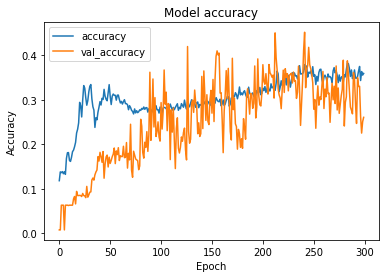

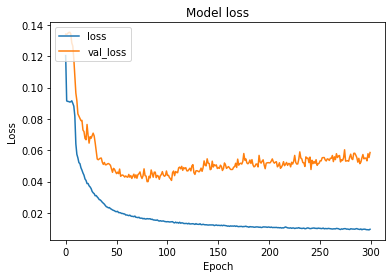

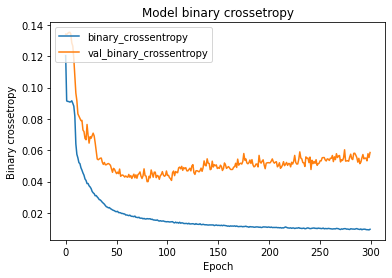

In [13]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['accuracy', 'val_accuracy'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['loss', 'val_loss'], loc='upper left')
plt.show()

plt.plot(history.history['binary_crossentropy'])
plt.plot(history.history['val_binary_crossentropy'])
plt.title('Model binary crossetropy')
plt.ylabel('Binary crossetropy')
plt.xlabel('Epoch')
plt.legend(['binary_crossentropy', 'val_binary_crossentropy'], loc='upper left')

plt.show()

In [31]:
test2_list = []
test_out = []
raw_notes = test.values
for i in range(len(raw_notes) - sequence_len):
    input_start = i
    input_end = i + sequence_len
    output_start = input_end
    output_end = output_start + 1

    # for every 32 notes sequence set next note as output
    test2_list.append(raw_notes[input_start:input_end])
    test_out.append(raw_notes[output_start:output_end])

test_out = list(np.array(test_out).reshape(-1, np.array(test_out).shape[-1]))

test2_list = np.array(test2_list)
test_out = np.array(test_out)

In [32]:
# test2_list
test2_list.shape

(11864, 32, 21)

In [33]:
# predict new notes
prediction = model.predict(test2_list[:], verbose=0)
# round prediction to 1 or 0
prediction = np.around(prediction)
# retype it to int
prediction = prediction.astype(int)

In [34]:
np.unique(prediction)

array([0, 1])

In [35]:
bpm = 120
file_name = "./output/rhcp_final.mid"
create_midi(bpm, prediction, mid.ticks_per_beat, file_name, instruments)
# create_midi(bpm, transcription.values, mid.ticks_per_beat, "./output/transcription.mid", instruments)

In [36]:
def bleu_metric_complete_lines(candidate, reference):
    correct_lines = 0
    for i,c in enumerate(candidate):
        # line of candidate is the same as reference
        if (c == reference[i]).all() == True:
            correct_lines += 1
    
    # probability of correct lines
    return correct_lines/len(reference)

def bleu_metric_ngrams(candidate, reference, ngram):
    correct_ngrams = 0
    offset = 0
    true_flag = True
    
    for i,c in enumerate(candidate):
        
#         print(candidate[i+offset], reference[i+offset], (candidate[i+offset] == reference[i+offset]).all())
        # line is correct
        if (candidate[i] == reference[i]).all() == True:
            pass
        else:
            true_flag = False

        # every ngram sequence
        if (i+1)%ngram == 0:
#             print(i, true_flag)
            # all sequence is correct
            if true_flag:
                correct_ngrams += 1
            true_flag = True
    
    allngrams = len(reference)/ngram
#     print(correct_ngrams, allngrams)
    # probability of correct lines
    return correct_ngrams/allngrams

def bleu_metric_single_notes(candidate, reference, length_of_line):
    correct_lines = 0
    probabilities = []
    for i,c in enumerate(candidate):
        # how many notes are correct in single line
        tmp = ((c == reference[i]) == True).sum()
        # probability of correct notes in single line
        probabilities.append(tmp/length_of_line)
    
    # geometric mean of probabilities
    return gmean(probabilities)

In [37]:
candidate = prediction.copy()
reference = test_list.copy()

In [38]:
bleu_metric_complete_lines(candidate, reference)

0.03632838840188807

In [39]:
bleu_metric_single_notes(candidate, reference, length_of_line=len(instruments))

30.812266989051192

In [40]:
bleu_metric_ngrams(candidate, reference, 16)

0.03236682400539447

In [41]:
end = time.time()
print(end - start)

9487.66513299942
